# Sleep Disorder Analysis

### By: G.N. Venkatapathiraju (B122048), Ishan Singh (B122056), Rishit Parija (B122093)

## Downloading Dataset

To downlaod the dataset, you need to register on Kaggle.com and generate Kaggle API.  
Downloading requires the Kaggle username and API Key.

In [1]:
import opendatasets as od
 
od.download(
    "https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset/data")

Skipping, found downloaded files in ".\sleep-health-and-lifestyle-dataset" (use force=True to force download)


## Importing all the required Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import ensemble
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers import Concatenate, Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Adagrad,Adadelta,Nadam,Adamax
from tensorflow.keras import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from IPython.display import clear_output
import os

## Data Handling and Preprocessing

In [70]:
file =('sleep-health-and-lifestyle-dataset\\Sleep_health_and_lifestyle_dataset.csv')
data = pd.read_csv(file)
 
# displaying the contents of the CSV file
data.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,Normal
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,Normal
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,Normal
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [71]:
# Splitting Blood Pressure into two column values, Systolic and Diastolic respectively
data[['Systolic', 'Diastolic']] = data['Blood Pressure'].str.split('/', expand=True)
data['Systolic'] = data['Systolic'].astype(int)
data['Diastolic'] = data['Diastolic'].astype(int)

# Mapping 0 for Male and 1 for Female to convert to numerical data
genMap = {'Male': 0, 'Female': 1}
data.Gender = data.Gender.map(genMap)

# Mapping 0 for Normal, 1 for Normal Weight, 2 for Overweight and 3 for Obese to convert to numerical data
bmiMap = {'Normal': 0, 'Normal Weight': 1, 'Overweight':2, 'Obese': 3}
data['BMI Category'] = data['BMI Category'].map(bmiMap)

# Mapping 0 for Apnea, 1 for None and 2 for Insomnia to convert to numerical data
diseaseMap = {'Sleep Apnea': 0, 'Normal':1, 'Insomnia': 2}
data['Sleep_Disorder_Target'] = data['Sleep Disorder'].map(diseaseMap)

# Dropping irrelevant columns  / split columns
data = data.drop(['Sleep Disorder', 'Person ID', 'Occupation', 'Blood Pressure'], axis = 1)

data.head()

,Gender,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Systolic,Diastolic,Sleep_Disorder_Target
0,0,27,6.1,6,42,6,2,77,4200,126,83,1
1,0,28,6.2,6,60,8,0,75,10000,125,80,1
2,0,28,6.2,6,60,8,0,75,10000,125,80,1
3,0,28,5.9,4,30,8,3,85,3000,140,90,0
4,0,28,5.9,4,30,8,3,85,3000,140,90,0


In [72]:
# Displaying Correlation of Target with each feature
data.corr()['Sleep_Disorder_Target']

Gender                    -0.253415
Age                       -0.232000
Sleep Duration            -0.177552
Quality of Sleep          -0.179592
Physical Activity Level   -0.433214
Stress Level               0.036058
BMI Category              -0.029101
Heart Rate                -0.205987
Daily Steps               -0.342098
Systolic                  -0.241786
Diastolic                 -0.310051
Sleep_Disorder_Target      1.000000
Name: Sleep_Disorder_Target, dtype: float64

### Describing the data

In [73]:
data.describe()

,Gender,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Systolic,Diastolic,Sleep_Disorder_Target
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,0.494652,42.184492,7.132086,7.312834,59.171123,5.385027,0.927807,70.165775,6816.844920,128.553476,84.649733,0.997326
std,0.500641,8.673133,0.795657,1.196956,20.830804,1.774526,1.010734,4.135676,1617.915679,7.748118,6.161611,0.644626
min,0.000000,27.000000,5.800000,4.000000,30.000000,3.000000,0.000000,65.000000,3000.000000,115.000000,75.000000,0.000000
25%,0.000000,35.250000,6.400000,6.000000,45.000000,4.000000,0.000000,68.000000,5600.000000,125.000000,80.000000,1.000000
50%,0.000000,43.000000,7.200000,7.000000,60.000000,5.000000,0.000000,70.000000,7000.000000,130.000000,85.000000,1.000000
75%,1.000000,50.000000,7.800000,8.000000,75.000000,7.000000,2.000000,72.000000,8000.000000,135.000000,90.000000,1.000000
max,1.000000,59.000000,8.500000,9.000000,90.000000,8.000000,3.000000,86.000000,10000.000000,142.000000,95.000000,2.000000


## Scaling the Dataset

In [74]:
# Initialize the scaler
scaler = MinMaxScaler()

# Exclude 'Person ID' and non-numeric columns
columns_to_normalize = ['Gender', 'Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level',
                         'Stress Level', 'BMI Category', 'Heart Rate', 'Daily Steps', 'Systolic', 'Diastolic']

# Apply Min-Max Scaling only to the selected numeric columns
data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

In [75]:
y_data = data['Sleep_Disorder_Target']
data = data.drop(['Sleep_Disorder_Target'], axis = 1)

In [76]:
data.head()

,Gender,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Systolic,Diastolic
0,0.0,0.00000,0.111111,0.4,0.2,0.6,0.666667,0.571429,0.171429,0.407407,0.40
1,0.0,0.03125,0.148148,0.4,0.5,1.0,0.000000,0.476190,1.000000,0.370370,0.25
2,0.0,0.03125,0.148148,0.4,0.5,1.0,0.000000,0.476190,1.000000,0.370370,0.25
3,0.0,0.03125,0.037037,0.0,0.0,1.0,1.000000,0.952381,0.000000,0.925926,0.75
4,0.0,0.03125,0.037037,0.0,0.0,1.0,1.000000,0.952381,0.000000,0.925926,0.75


## HeatMap to represent co-relation

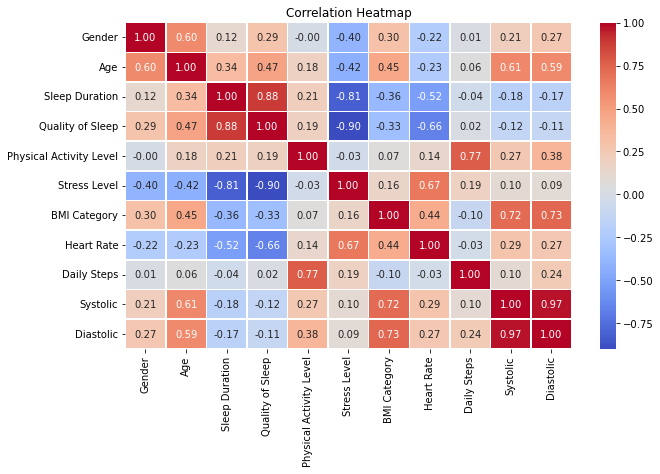

In [77]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

## Applying PCA for dimensionality reduction

In [78]:
pca_data = PCA(n_components = 0.95) #Keeping 95% variance in the data.
X_data = pca_data.fit_transform(data)
pca_df = pd.DataFrame(X_data, columns = [f'PC{i+1}' for i in range(X_data.shape[1])])

In [79]:
explained_variance = pca_data.explained_variance_ratio_
explained_variance

array([0.35631629, 0.29125299, 0.16613399, 0.10033979, 0.03390281,
       0.02078562])

In [80]:
pca_df['Sleep_Disorder_Target'] = y_data
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,Sleep_Disorder_Target
0,-0.695531,0.420083,0.385407,0.320670,0.445274,0.159853,1
1,-0.956148,0.295033,-0.144652,-0.458087,-0.131212,0.017546,1
2,-0.956148,0.295033,-0.144652,-0.458087,-0.131212,0.017546,1
3,-0.650163,1.281758,0.607187,0.590807,0.432989,-0.143782,0
4,-0.650163,1.281758,0.607187,0.590807,0.432989,-0.143782,0


In [81]:
# Creating backup datasets
ml_data = dl_data = pca_df

In [82]:
# One-hot encode the 'Sleep_Disorder_Target' column for use in Neural Networks
dl_data = pd.get_dummies(dl_data, columns=['Sleep_Disorder_Target'], dtype=int)
# Rename the new columns
dl_data = dl_data.rename(columns={
    'Sleep_Disorder_Target_0': 'Apnea',
    'Sleep_Disorder_Target_1': 'Normal',
    'Sleep_Disorder_Target_2': 'Insomnia'
})

dl_data.head()

,PC1,PC2,PC3,PC4,PC5,PC6,Apnea,Normal,Insomnia
0,-0.695531,0.420083,0.385407,0.320670,0.445274,0.159853,0,1,0
1,-0.956148,0.295033,-0.144652,-0.458087,-0.131212,0.017546,0,1,0
2,-0.956148,0.295033,-0.144652,-0.458087,-0.131212,0.017546,0,1,0
3,-0.650163,1.281758,0.607187,0.590807,0.432989,-0.143782,1,0,0
4,-0.650163,1.281758,0.607187,0.590807,0.432989,-0.143782,1,0,0


## Randomly splitting data into training and testing set

In [83]:
X = dl_data.drop(columns=['Apnea', 'Normal', 'Insomnia'])  # All features (excluding the target columns)
y = dl_data[['Apnea', 'Normal', 'Insomnia']]  # One-hot encoded target

# Stratified split to keep the same distribution of classes in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,   # 80-20 train-test split (can adjust as per your needs)
    random_state=42, # For reproducibility
    stratify=y       # Ensures same distribution of classes in both train and test
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 299
Test set size: 75


## Model Design

In [89]:
model=Sequential()
# Input layer
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())  # Batch Normalization for better training stability
model.add(Dropout(0.3))  # Dropout to prevent overfitting
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())  # Batch Normalization for better training stability
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())  # Batch Normalization for better training stability
model.add(Dropout(0.3))
# Output layer with softmax for multi-class classification (3 classes)
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 64)                448       
_________________________________________________________________
batch_normalization_12 (Batc (None, 64)                256       
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_13 (Batc (None, 32)                128       
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)               

## Compiling and Fitting the model

In [90]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['AUC', 'accuracy', 'Precision', 'Recall'])

early_stopping = EarlyStopping(monitor='val_loss',  # or 'val_accuracy'
                               patience=3,  # Number of epochs with no improvement after which training will be stopped
                               restore_best_weights=True)  # Restore the best model weights

# Train the model
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True,verbose=1, mode='max')
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test),callbacks=[checkpoint])

Epoch 1/150
10/10 [==============================] - 2s 50ms/step - loss: 1.5673 - auc: 0.5740 - accuracy: 0.3913 - precision: 0.4102 - recall: 0.3512 - val_loss: 1.0316 - val_auc: 0.8354 - val_accuracy: 0.6533 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00001: val_accuracy improved from -inf to 0.65333, saving model to best_model.h5
Epoch 2/150
10/10 [==============================] - 0s 13ms/step - loss: 1.4287 - auc: 0.6190 - accuracy: 0.4314 - precision: 0.4556 - recall: 0.3779 - val_loss: 0.9767 - val_auc: 0.9176 - val_accuracy: 0.6667 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00002: val_accuracy improved from 0.65333 to 0.66667, saving model to best_model.h5
Epoch 3/150
10/10 [==============================] - 0s 12ms/step - loss: 1.1191 - auc: 0.7330 - accuracy: 0.5753 - precision: 0.5900 - recall: 0.5151 - val_loss: 0.9277 - val_auc: 0.9409 - val_accuracy: 0.7600 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00003: val_accuracy im

10/10 [==============================] - 0s 13ms/step - loss: 0.5932 - auc: 0.9161 - accuracy: 0.8328 - precision: 0.8462 - recall: 0.8094 - val_loss: 0.3170 - val_auc: 0.9989 - val_accuracy: 0.9867 - val_precision: 1.0000 - val_recall: 0.9467

Epoch 00026: val_accuracy did not improve from 0.98667
Epoch 27/150
10/10 [==============================] - 0s 14ms/step - loss: 0.5188 - auc: 0.9296 - accuracy: 0.8696 - precision: 0.8803 - recall: 0.8361 - val_loss: 0.3004 - val_auc: 0.9990 - val_accuracy: 0.9867 - val_precision: 1.0000 - val_recall: 0.9600

Epoch 00027: val_accuracy did not improve from 0.98667
Epoch 28/150
10/10 [==============================] - 0s 14ms/step - loss: 0.4927 - auc: 0.9357 - accuracy: 0.8863 - precision: 0.9056 - recall: 0.8662 - val_loss: 0.2837 - val_auc: 0.9989 - val_accuracy: 0.9733 - val_precision: 1.0000 - val_recall: 0.9600

Epoch 00028: val_accuracy did not improve from 0.98667
Epoch 29/150
10/10 [==============================] - 0s 13ms/step - loss:

10/10 [==============================] - 0s 13ms/step - loss: 0.4682 - auc: 0.9370 - accuracy: 0.8696 - precision: 0.8759 - recall: 0.8495 - val_loss: 0.1317 - val_auc: 0.9992 - val_accuracy: 0.9600 - val_precision: 0.9863 - val_recall: 0.9600

Epoch 00052: val_accuracy did not improve from 0.98667
Epoch 53/150
10/10 [==============================] - 0s 13ms/step - loss: 0.4589 - auc: 0.9378 - accuracy: 0.8763 - precision: 0.8951 - recall: 0.8562 - val_loss: 0.1280 - val_auc: 0.9993 - val_accuracy: 0.9600 - val_precision: 0.9863 - val_recall: 0.9600

Epoch 00053: val_accuracy did not improve from 0.98667
Epoch 54/150
10/10 [==============================] - 0s 13ms/step - loss: 0.4990 - auc: 0.9322 - accuracy: 0.8595 - precision: 0.8746 - recall: 0.8395 - val_loss: 0.1242 - val_auc: 0.9995 - val_accuracy: 0.9733 - val_precision: 0.9863 - val_recall: 0.9600

Epoch 00054: val_accuracy did not improve from 0.98667
Epoch 55/150
10/10 [==============================] - 0s 12ms/step - loss:

10/10 [==============================] - 0s 13ms/step - loss: 0.4600 - auc: 0.9329 - accuracy: 0.8595 - precision: 0.8715 - recall: 0.8395 - val_loss: 0.1042 - val_auc: 0.9995 - val_accuracy: 0.9867 - val_precision: 0.9865 - val_recall: 0.9733

Epoch 00078: val_accuracy did not improve from 0.98667
Epoch 79/150
10/10 [==============================] - 0s 14ms/step - loss: 0.4378 - auc: 0.9394 - accuracy: 0.8796 - precision: 0.8840 - recall: 0.8662 - val_loss: 0.1056 - val_auc: 0.9995 - val_accuracy: 0.9867 - val_precision: 0.9863 - val_recall: 0.9600

Epoch 00079: val_accuracy did not improve from 0.98667
Epoch 80/150
10/10 [==============================] - 0s 12ms/step - loss: 0.4314 - auc: 0.9373 - accuracy: 0.8963 - precision: 0.9007 - recall: 0.8796 - val_loss: 0.1091 - val_auc: 0.9994 - val_accuracy: 0.9867 - val_precision: 0.9863 - val_recall: 0.9600

Epoch 00080: val_accuracy did not improve from 0.98667
Epoch 81/150
10/10 [==============================] - 0s 14ms/step - loss:

10/10 [==============================] - 0s 13ms/step - loss: 0.4005 - auc: 0.9491 - accuracy: 0.8829 - precision: 0.9000 - recall: 0.8729 - val_loss: 0.1104 - val_auc: 0.9993 - val_accuracy: 0.9867 - val_precision: 0.9865 - val_recall: 0.9733

Epoch 00104: val_accuracy did not improve from 0.98667
Epoch 105/150
10/10 [==============================] - 0s 13ms/step - loss: 0.3875 - auc: 0.9523 - accuracy: 0.8930 - precision: 0.9038 - recall: 0.8796 - val_loss: 0.1088 - val_auc: 0.9995 - val_accuracy: 0.9867 - val_precision: 0.9863 - val_recall: 0.9600

Epoch 00105: val_accuracy did not improve from 0.98667
Epoch 106/150
10/10 [==============================] - 0s 13ms/step - loss: 0.4236 - auc: 0.9412 - accuracy: 0.8930 - precision: 0.8956 - recall: 0.8896 - val_loss: 0.1077 - val_auc: 0.9994 - val_accuracy: 0.9733 - val_precision: 0.9863 - val_recall: 0.9600

Epoch 00106: val_accuracy did not improve from 0.98667
Epoch 107/150
10/10 [==============================] - 0s 13ms/step - lo

10/10 [==============================] - 0s 17ms/step - loss: 0.4088 - auc: 0.9438 - accuracy: 0.8863 - precision: 0.8908 - recall: 0.8729 - val_loss: 0.1043 - val_auc: 0.9993 - val_accuracy: 0.9867 - val_precision: 0.9867 - val_recall: 0.9867

Epoch 00130: val_accuracy did not improve from 0.98667
Epoch 131/150
10/10 [==============================] - 0s 20ms/step - loss: 0.4106 - auc: 0.9420 - accuracy: 0.9030 - precision: 0.9085 - recall: 0.8963 - val_loss: 0.1048 - val_auc: 0.9993 - val_accuracy: 0.9867 - val_precision: 0.9867 - val_recall: 0.9867

Epoch 00131: val_accuracy did not improve from 0.98667
Epoch 132/150
10/10 [==============================] - 0s 24ms/step - loss: 0.3765 - auc: 0.9561 - accuracy: 0.8829 - precision: 0.8969 - recall: 0.8729 - val_loss: 0.1065 - val_auc: 0.9993 - val_accuracy: 0.9867 - val_precision: 0.9867 - val_recall: 0.9867

Epoch 00132: val_accuracy did not improve from 0.98667
Epoch 133/150
10/10 [==============================] - 0s 21ms/step - lo

############################

## ROC - AUC Curve

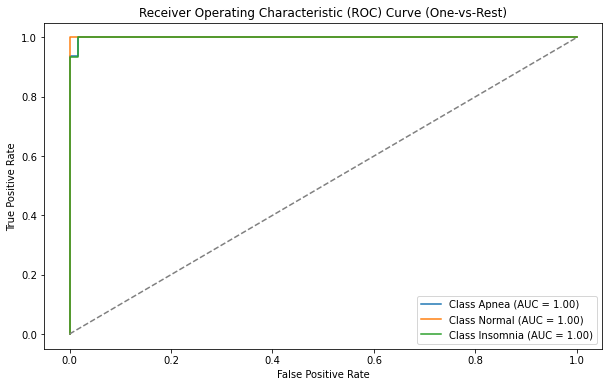

In [91]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)  # Get the class with the highest probability
y_test_np = y_test.to_numpy()  # Convert y_test to numpy array

# Accuracy
accuracy = accuracy_score(np.argmax(y_test_np, axis=1), y_pred)

# ROC-AUC Curve (One-vs-Rest)
n_classes = y_test_np.shape[1]
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_np[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC-AUC Curves for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {["Apnea", "Normal", "Insomnia"][i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

## Precision - Recall Curve (One vs Rest)

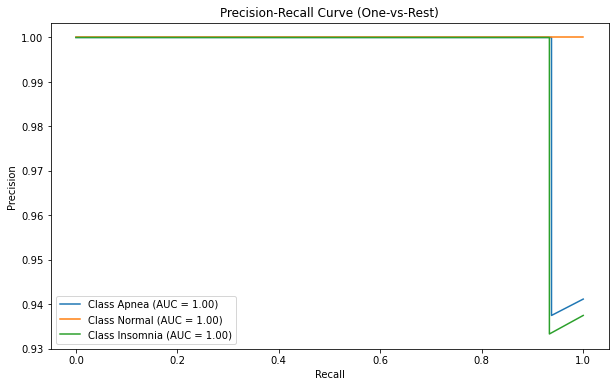

In [92]:
precision = {}
recall = {}
pr_auc = {}

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_np[:, i], y_pred_prob[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

# Plot the Precision-Recall curves for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f'Class {["Apnea", "Normal", "Insomnia"][i]} (AUC = {pr_auc[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (One-vs-Rest)')
plt.legend(loc='lower left')
plt.show()

## Confusion Matrix

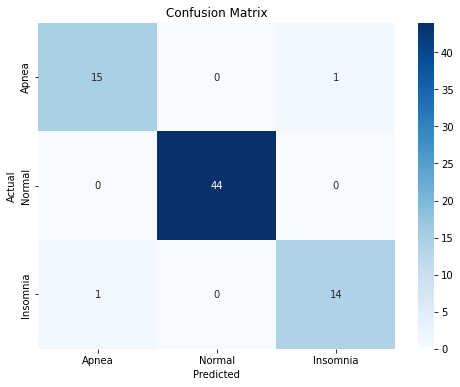

Accuracy: 0.9733


In [93]:
cm = confusion_matrix(np.argmax(y_test_np, axis=1), y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Apnea', 'Normal', 'Insomnia'], yticklabels=['Apnea', 'Normal', 'Insomnia'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print Accuracy
print(f'Accuracy: {accuracy:.4f}')

## Training History (Accuracy and Loss) over Epochs

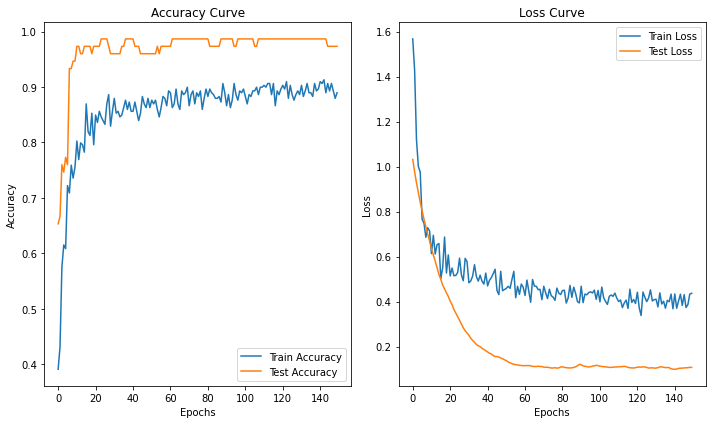

Accuracy: 0.97


In [94]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Print Accuracy
print(f'Accuracy: {accuracy:.2f}')

## Classification Report

In [95]:
report = classification_report(np.argmax(y_test_np, axis=1), y_pred, target_names=['Apnea', 'Normal', 'Insomnia'])
print('Classification Report:')
print(report)

Classification Report:
              precision    recall  f1-score   support

       Apnea       0.94      0.94      0.94        16
      Normal       1.00      1.00      1.00        44
    Insomnia       0.93      0.93      0.93        15

    accuracy                           0.97        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.97      0.97      0.97        75



## Saving the best model

In [34]:
model.save('best_model.h5')

## Loading the best Model

3/3 [==============================] - 0s 7ms/step - loss: 0.3492 - auc: 0.9987 - accuracy: 0.9867 - precision: 1.0000 - recall: 0.9467


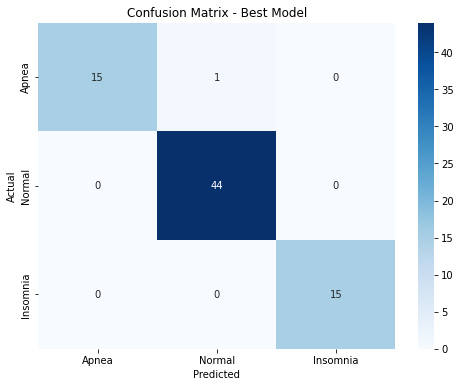

Best Model Stored - Accuracy: 0.9867, Loss: 0.3492
Precision: 1.0000, Recall: 0.9467, AUC: 0.9987


In [96]:
# Load the best model saved during training
best_model = load_model('best_model.h5')

# Get the final accuracy and other metrics on the validation set
loss, ac, accuracy, precision, recall = best_model.evaluate(X_test, y_test)
y_pred_prob = best_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)  # Get the predicted class with the highest probability
y_test_np = y_test.to_numpy()
cm = confusion_matrix(np.argmax(y_test_np, axis=1), y_pred)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Apnea', 'Normal', 'Insomnia'], yticklabels=['Apnea', 'Normal', 'Insomnia'])
plt.title('Confusion Matrix - Best Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
# Print the results
print(f"Best Model Stored - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {ac:.4f}")

10/10 [==============================] - 0s 5ms/step - loss: 0.4675 - auc: 0.9458 - accuracy: 0.9030 - precision: 0.9100 - recall: 0.8796


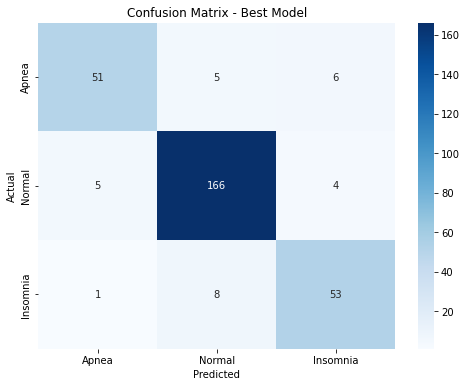

Best Model Stored - Accuracy: 0.9030, Loss: 0.4675
Precision: 0.9100, Recall: 0.8796, AUC: 0.9458


In [98]:
# Load the best model saved during training
best_model = load_model('best_model.h5')

# Get the final accuracy and other metrics on the validation set
loss, ac, accuracy, precision, recall = best_model.evaluate(X_train, y_train, batch_size = 32)
y_pred_prob = best_model.predict(X_train)
y_pred = np.argmax(y_pred_prob, axis=1)  # Get the predicted class with the highest probability
y_test_np = y_train.to_numpy()
cm = confusion_matrix(np.argmax(y_test_np, axis=1), y_pred)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Apnea', 'Normal', 'Insomnia'], yticklabels=['Apnea', 'Normal', 'Insomnia'])
plt.title('Confusion Matrix - Best Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
# Print the results
print(f"Best Model Stored - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {ac:.4f}")

# Implementing Random Forest

In [99]:
from sklearn.model_selection import train_test_split

# Features and target
X = ml_data.drop(columns=['Sleep_Disorder_Target'])
y = ml_data['Sleep_Disorder_Target']

# Stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 280
Test set size: 94


Random Forest - Accuracy: 0.8830
Classification Report:
              precision    recall  f1-score   support

      Normal       0.78      0.90      0.84        20
    Insomnia       0.93      0.93      0.93        55
       Apnea       0.88      0.74      0.80        19

    accuracy                           0.88        94
   macro avg       0.86      0.85      0.85        94
weighted avg       0.89      0.88      0.88        94



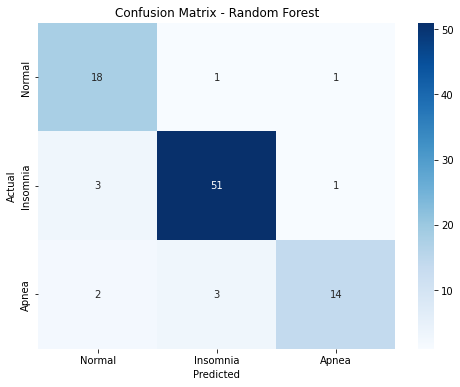

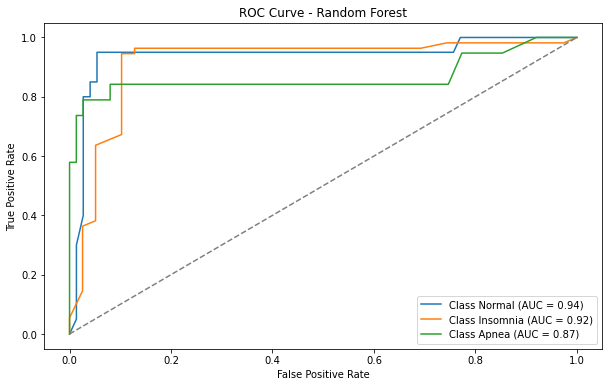

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

# Initialize the model
rf_model = RandomForestClassifier(n_estimators=50, max_depth=4, random_state=42, n_jobs=-1)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Classification Report
report = classification_report(y_test, y_pred, target_names=['Normal', 'Insomnia', 'Apnea'])

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# ROC AUC Curve (One-vs-Rest)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Binarize the output
fpr, tpr, roc_auc = {}, {}, {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Display metrics
print(f"Random Forest - Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{report}")

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Insomnia', 'Apnea'], yticklabels=['Normal', 'Insomnia', 'Apnea'])
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve (One-vs-Rest)
plt.figure(figsize=(10, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {["Normal", "Insomnia", "Apnea"][i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()


Random Forest - Accuracy: 0.9250
Classification Report:
              precision    recall  f1-score   support

      Normal       0.89      0.88      0.89        58
    Insomnia       0.95      0.96      0.95       164
       Apnea       0.88      0.88      0.88        58

    accuracy                           0.93       280
   macro avg       0.91      0.91      0.91       280
weighted avg       0.92      0.93      0.92       280



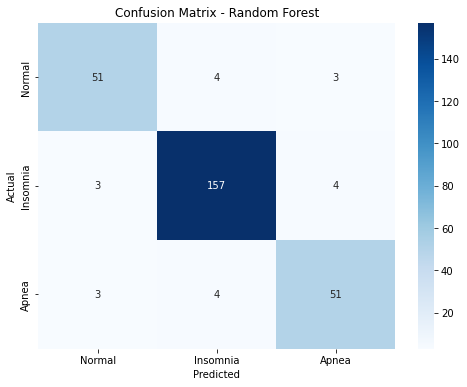

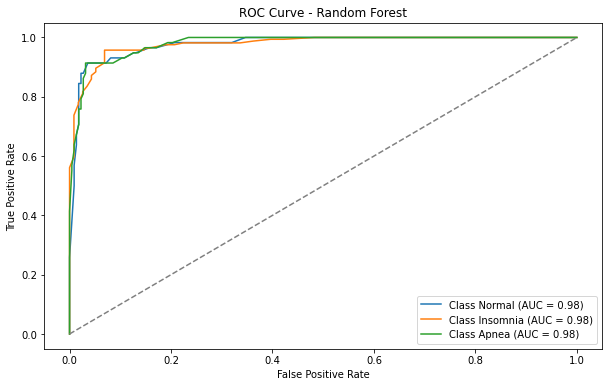

In [43]:
# Predict on test data
y_pred = rf_model.predict(X_train)
y_pred_prob = rf_model.predict_proba(X_train)

# Accuracy
accuracy = accuracy_score(y_train, y_pred)

# Classification Report
report = classification_report(y_train, y_pred, target_names=['Normal', 'Insomnia', 'Apnea'])

# Confusion Matrix
cm = confusion_matrix(y_train, y_pred)

# ROC AUC Curve (One-vs-Rest)
y_test_bin = label_binarize(y_train, classes=[0, 1, 2])  # Binarize the output
fpr, tpr, roc_auc = {}, {}, {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Display metrics
print(f"Random Forest - Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{report}")

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Insomnia', 'Apnea'], yticklabels=['Normal', 'Insomnia', 'Apnea'])
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve (One-vs-Rest)
plt.figure(figsize=(10, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {["Normal", "Insomnia", "Apnea"][i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()
